In [207]:
import math, random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical

In [208]:
torch.manual_seed(51)

In [209]:
%matplotlib inline
import matplotlib.pyplot as plt

# Fetching data from Quandl

Don't bother with this step if the data's already saved from the Pickle below.

In [210]:
import quandl

apl_stock=quandl.get('WIKI/AAPL', start_date="2014-01-01", end_date="2018-08-20" )
msf_stock=quandl.get('WIKI/MSFT', start_date="2014-01-01", end_date="2018-08-20")
apl_open = apl_stock["Open"].values
apl_close = apl_stock["Close"].values
msf_open = msf_stock["Open"].values
msf_close = msf_stock["Close"].values

In [211]:
msf_stock.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2014-01-02,37.350,37.40,37.10,37.16,30632200.0,0.0,1.0,33.704254,33.749373,33.478656,33.532800,30632200.0
2014-01-03,37.200,37.22,36.60,36.91,31134800.0,0.0,1.0,33.568895,33.586943,33.027461,33.307202,31134800.0
2014-01-06,36.850,36.89,36.11,36.13,43603700.0,0.0,1.0,33.253059,33.289154,32.585290,32.603338,43603700.0
2014-01-07,36.325,36.49,36.21,36.41,35802800.0,0.0,1.0,32.779304,32.928198,32.675529,32.856007,35802800.0
2014-01-08,36.000,36.14,35.58,35.76,59971700.0,0.0,1.0,32.486028,32.612362,32.107024,32.269454,59971700.0


## Examining the data

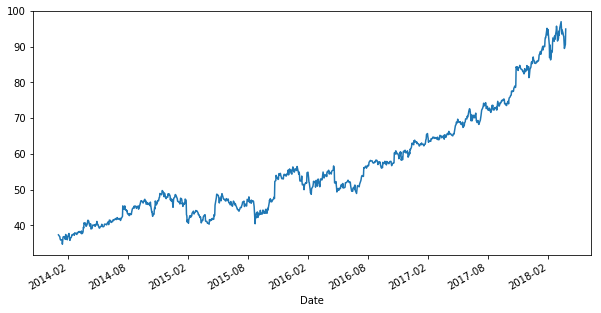

In [212]:
msf_stock['Open'].plot(figsize=(10,5))

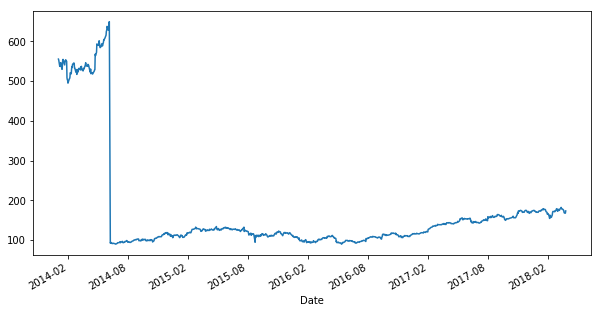

In [213]:
apl_stock['Open'].plot(figsize=(10,5))

## Seems Weird! What just happened?

Turns out that on 9 June 2014, AAPL had a stock split in the ratio of 1:7(Google it). So, I'll divide everything before element 9 June 2014(excluding it, of course) by 7 to correct for this.

In [214]:
apl_stock['Open'].loc[:'2014-06-09'].iloc[:-1] /= 7

In [215]:
apl_stock['Close'].loc[:'2014-06-09'].iloc[:-1] /= 7

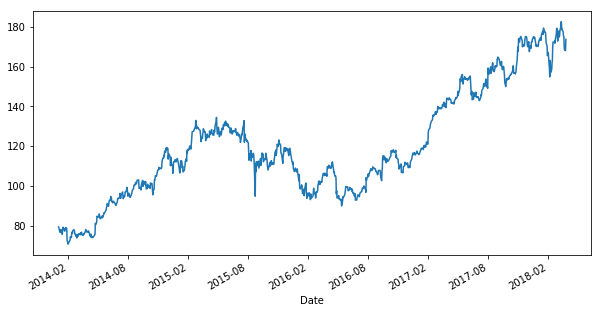

In [216]:
apl_stock['Open'].plot(figsize=(10,5))

In [217]:
apl_open = apl_stock['Open'].values

## Looks better, now remove the general upwards trend.

It's necessary to de-trend the data. Otherwise MSFT and AAPL are on completely different scales and we could hardly expect our algorithm to learn how to trade apples and oranges together. Additionally, we want the algorithm to learn the fundamentals of the stock signal - buy if it's going to rise. If we didn't remove the trend, maybe it'd only learn to buy at the start and hold til the end since a general upwards trend happens.

SciPy's signal processing module has a function that fits a linear least-squares model to the data and subtracts it for us.

In [218]:
from scipy import signal

In [219]:
msf_open = signal.detrend(msf_open)
msf_close = signal.detrend(msf_close)

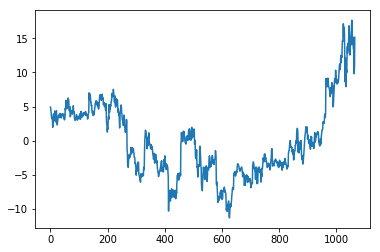

In [220]:
plt.plot(range(0,len(msf_open)), msf_open)

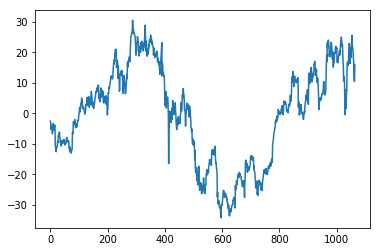

In [221]:
apl_open = signal.detrend(apl_open)
apl_close = signal.detrend(apl_close)
plt.plot(range(0, len(apl_open)), apl_open)

## Negative values?

It doesn't make sense to buy a share at a negative value. But since the model will learn to maximize reward, we can just shift it up by a constant number so it's always positive.

In [222]:
print(apl_open.min())
print(apl_close.min())
print(msf_open.min())
print(msf_close.min())

-34.32168425572118
-34.447411978136344
-11.365775305682881
-11.834602851532026


Choose 35 (looking at the above values obviously)

In [223]:
apl_open += 35.
apl_close += 35.
msf_open += 35.
msf_close += 35.

## Saving the transformed data

In [224]:
import pickle
with open("aplmsfopenclose.pkl", "wb+") as f:
    pickle.dump({"ao":apl_open, "ac": apl_close, "mo": msf_open, "mc": msf_close}, f)

## If the data's already saved, skip the above and load it here instead

In [225]:
import pickle
with open("aplmsfopenclose.pkl", "rb") as f:
    d = pickle.load(f)
apl_open = d["ao"]
apl_close = d["ac"]
msf_open = d["mo"]
msf_close = d["mc"]

Verify the same by plotting the AAPL stock.

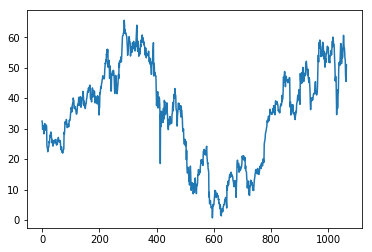

In [184]:
plt.plot(range(0,len(apl_open)), apl_open)

# Build the environment

* For starting cash, we can't use a dollar value because of the transformed data. After shifting earlier, we know the mean of each opening price should be 35, so I'm starting the agent off with enough cash to buy ~2.5 shares.
* This starting cash is the mean starting cash; it can be randomized by altering the std parameter
* action space = 0 buy apple, 1 sell apple, 2 do nothing, 3 buy msft, 4 sell msft, quantity. eg. [0, 100]
* obs space: apl shares, msft shares, cash in bank [2], today apl open [3], today msf open [4], portfolio value [5], 5 day window [6apl, 7msf] = 8
* If bot gets to the end with more than one of each share, we give it a bonus for having a diversified portfolio!
* Buys and sells attract a 10% brokerage fee

In [185]:
class TradingEnvironment():

    def __init__(self, starting_cash_mean=200., max_stride=5, series_length=208, starting_point=1, randomize_cash_std=0, 
                 starting_shares_mean=0., randomize_shares_std=0., inaction_penalty=0.):
        self.starting_shares_mean = starting_shares_mean
        self.randomize_shares_std = randomize_shares_std
        self.starting_cash_mean = starting_cash_mean
        self.randomize_cash_std = randomize_cash_std
        
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        
        self.series_length = series_length
        self.starting_point = starting_point
        self.cur_timestep = self.starting_point
        
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.starting_portfolio_value = self.portfolio_value()
        self.state[2] = self.starting_cash
        self.state[3] = apl_open[self.cur_timestep]
        self.state[4] = msf_open[self.cur_timestep]
        self.state[5] = self.starting_portfolio_value
        self.state[6] = self.five_day_window()[0]
        self.state[7] = self.five_day_window()[1]
        
        self.max_stride = max_stride
        self.stride = self.max_stride # no longer varying it
        
        self.done = False
        self.diversification_bonus = 1.
        self.inaction_penalty = inaction_penalty
    
    def portfolio_value(self):
        return (self.state[0] * apl_close[self.cur_timestep]) + (self.state[1] * msf_close[self.cur_timestep]) + self.state[2]
    
    def next_opening_price(self):
        step = self.cur_timestep + self.stride
        return [apl_open[step], msf_open[step]]
    
    def five_day_window(self):
        step = self.cur_timestep
        if step < 5:
            return [apl_open[0], msf_open[0]]
        apl5 = apl_open[step-5:step].mean()
        msf5 = msf_open[step-5:step].mean()
        return [apl5, msf5]
    
    def step(self, action):
        action = [action, 1.]
        cur_timestep = self.cur_timestep
        ts_left = self.series_length - (cur_timestep - self.starting_point)
        retval = None
        cur_value = self.portfolio_value()
        gain = cur_value - self.starting_portfolio_value
        
        if cur_timestep >= self.starting_point + (self.series_length * self.stride):
            new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
            self.state = new_state
            bonus = 0.
            if self.state[0] > 0 and self.state[1] > 0:
                bonus = self.diversification_bonus
            return new_state, cur_value + bonus + gain, True, { "msg": "done"}
        
        if action[0] == 2:
            new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                    cur_value, *self.five_day_window()]
            self.state = new_state
            retval = new_state, -self.inaction_penalty-ts_left +gain, False, { "msg": "nothing" }
            
        if action[0] == 0:
            if action[1] * apl_open[cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "bankrupted self"}
            else:
                apl_shares = self.state[0] + action[1]
                cash_spent = action[1] * apl_open[cur_timestep] * 1.1
                new_state = [apl_shares, self.state[1], self.state[2] - cash_spent, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "bought AAPL"}
                
        if action[0] == 3:
            if action[1] * msf_open[cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval =  new_state, -ts_left+gain/2, True, { "msg": "bankrupted self"}
            else:
                msf_shares = self.state[1] + action[1]
                cash_spent = action[1] * msf_open[cur_timestep] * 1.1
                new_state = [self.state[0], msf_shares, self.state[2] - cash_spent, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "bought MSFT"}
        

        if action[0] == 1:
            if action[1] > self.state[0]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "sold more than have"}
            else:
                apl_shares = self.state[0] - action[1]
                cash_gained = action[1] * apl_open[cur_timestep] * 0.9
                new_state = [apl_shares, self.state[1], self.state[2] + cash_gained, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "sold AAPL"}
                
        if action[0] == 4:
            if action[1] > self.state[1]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "sold more than have"}
            else:
                msf_shares = self.state[1] - action[1]
                cash_gained = action[1] * msf_open[cur_timestep] * 0.9
                new_state = [self.state[0], msf_shares, self.state[2] + cash_gained, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "sold MSFT"}
                
        self.cur_timestep += self.stride
        return retval
    
    def reset(self):
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        self.cur_timestep = self.starting_point
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[2] = self.starting_cash
        self.state[3] = apl_open[self.cur_timestep]
        self.state[4] = msf_open[self.cur_timestep]
        self.starting_portfolio_value = self.portfolio_value()
        self.state[5] = self.starting_portfolio_value
        self.state[6] = self.five_day_window()[0]
        self.state[7] = self.five_day_window()[1]       
        self.done = False
        return self.state

In [186]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(8, 128)
        self.hidden_1 = nn.Linear(128, 128)
        self.hidden_2 = nn.Linear(32,31)
        self.hidden_state = torch.tensor(torch.zeros(2,1,32)).cuda()
        self.rnn = nn.GRU(128, 32, 2)
        self.action_head = nn.Linear(31, 5)
        self.value_head = nn.Linear(31, 1)
        self.saved_actions = []
        self.rewards = []

    def reset_hidden(self):
        self.hidden_state = torch.tensor(torch.zeros(2,1,32)).cuda()
        
    def forward(self, x):
        x = torch.tensor(x).cuda()
        x = torch.sigmoid(self.input_layer(x))
        x = torch.tanh(self.hidden_1(x))
        x, self.hidden_state = self.rnn(x.view(1,-1,128), self.hidden_state.data)
        x = F.relu(self.hidden_2(x.squeeze()))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        if action == 1 and env.state[0] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        if action == 4 and env.state[1] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

In [187]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
model = Policy().cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [188]:
env.reset()
# In case you're running this a second time with the same model, delete the gradients
del model.rewards[:]
del model.saved_actions[:]

gamma = 0.9
log_interval = 60

def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []
    for r in model.rewards[::-1]:
        R = r + (gamma * R)
        rewards.insert(0, R)
    rewards = torch.tensor(rewards)
    
    epsilon = (torch.rand(1) / 1e4) - 5e-5
    # With different architectures, I found the following standardization step sometimes
    # helpful, sometimes unhelpful.
    # rewards = (rewards - rewards.mean()) / (rewards.std(unbiased=False) + epsilon)
    # Alternatively, comment it out and use the following line instead:
    rewards += epsilon
    
    for (log_prob, value), r in zip(saved_actions, rewards):
        reward = torch.tensor(r - value.item()).cuda()
        policy_losses.append(-log_prob * reward)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([r]).cuda()))
        
    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss = torch.clamp(loss, -1e-5, 1e5)
    loss.backward()
    optimizer.step()
    del model.rewards[:]
    del model.saved_actions[:]

running_reward = 0
for episode in range(0, 4000):
    state = env.reset()
    reward = 0
    done = False
    msg = None
    while not done:
        action = model.act(state)
        state, reward, done, msg = env.step(action)
        model.rewards.append(reward)
        if done:
            break
    running_reward = running_reward * (1 - 1/log_interval) + reward * (1/log_interval)
    finish_episode()
    # Resetting the hidden state seems unnecessary - it's effectively random from the previous
    # episode anyway, more random than a bunch of zeros.
    # model.reset_hidden()
    if msg["msg"] == "done" and env.portfolio_value() > env.starting_portfolio_value * 1.1 and running_reward > 500:
        print("Early Stopping: " + str(int(reward)))
        break
    if episode % log_interval == 0:
        print("""Episode {}: started at {:.1f}, finished at {:.1f} because {} @ t={}, \
last reward {:.1f}, running reward {:.1f}""".format(episode, env.starting_portfolio_value, \
              env.portfolio_value(), msg["msg"], env.cur_timestep, reward, running_reward))

Episode 0: started at 7840.0, finished at 8731.0 because bankrupted self @ t=861, last reward 968.3, running reward 16.1
Episode 60: started at 8469.1, finished at 7164.9 because bankrupted self @ t=425, last reward -563.9, running reward 293.0
Episode 120: started at 8430.1, finished at 6445.7 because bankrupted self @ t=505, last reward -312.1, running reward 209.9
Episode 180: started at 7199.0, finished at 6013.4 because bankrupted self @ t=501, last reward -456.0, running reward 332.5
Early Stopping: 12395


## Let's see how it does in practice, on the training data

In [189]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)

total_rewards = 0
total_profits = 0
failed_goes = 0
num_goes = 50

for j in range(num_goes):
    env.reset()
    reward_this_go = -1e8
    for i in range(0,env.series_length + 1):
        action = model.act(env.state)
        next_state, reward, done, msg = env.step(action)
        if msg["msg"] == "done":
            reward_this_go = env.portfolio_value()
            break
        if done:
            break
    total_profits += (env.portfolio_value() - env.starting_portfolio_value) / env.starting_portfolio_value
    if reward_this_go == -1e8:
        failed_goes += 1
    else:
        total_rewards += reward_this_go

if failed_goes == num_goes:
    print("Failed all")
else:
    print("Failed goes: {} / {}, Avg Rewards per successful game: {}".format(failed_goes, num_goes, total_rewards / (num_goes - failed_goes)))
    print("Avg % profit per game: {}".format(total_profits / num_goes))
    print("Avg % profit per finished game: {}".format(total_profits / (num_goes - failed_goes)))

Failed goes: 48 / 50, Avg Rewards per successful game: 9886.1015625
Avg % profit per game: -0.029146483168005943
Avg % profit per finished game: -0.7286620736122131


## And here's how a sample trading run might look

In [190]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
env.reset()
print("starting portfolio value {}".format(env.portfolio_value()))
for i in range(0,env.series_length + 1):
    action = model.act(env.state)
    next_state, reward, done, msg = env.step(action)
    if msg["msg"] == 'bankrupted self':
        print('bankrupted self by 1')
        break
    if msg["msg"] == 'sold more than have':
        print('sold more than have by 1')
        break
    print("{}, have {} aapl and {} msft and {} cash".format(msg["msg"], next_state[0], next_state[1], next_state[2]))
    if msg["msg"] == "done":
        print(next_state, reward)
        print("total portfolio value {}".format(env.portfolio_value()))
        break

starting portfolio value 7798.888671875
sold AAPL, have 97.0 aapl and 95.0 msft and 1113.798095703125 cash
nothing, have 97.0 aapl and 95.0 msft and 1113.798095703125 cash
sold AAPL, have 96.0 aapl and 95.0 msft and 1142.1678466796875 cash
sold AAPL, have 95.0 aapl and 95.0 msft and 1169.946044921875 cash
bought MSFT, have 95.0 aapl and 96.0 msft and 1128.222900390625 cash
bought MSFT, have 95.0 aapl and 97.0 msft and 1084.91357421875 cash
nothing, have 95.0 aapl and 97.0 msft and 1084.91357421875 cash
bought AAPL, have 96.0 aapl and 97.0 msft and 1054.771240234375 cash
bought MSFT, have 96.0 aapl and 98.0 msft and 1012.2362060546875 cash
sold AAPL, have 95.0 aapl and 98.0 msft and 1034.9642333984375 cash
sold AAPL, have 94.0 aapl and 98.0 msft and 1058.3857421875 cash
bought AAPL, have 95.0 aapl and 98.0 msft and 1030.4879150390625 cash
nothing, have 95.0 aapl and 98.0 msft and 1030.4879150390625 cash
bought MSFT, have 95.0 aapl and 99.0 msft and 987.083740234375 cash
bought AAPL, hav

In [191]:
apl_open_orig = apl_stock["Open"].values
apl_close_orig = apl_stock["Close"].values
msf_open_orig = msf_stock["Open"].values
msf_close_orig = msf_stock["Close"].values
apl_open_orig[:108] /= 7
apl_close_orig[:108] /= 7

In [192]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
env.reset()
complete_game = False
while not complete_game:
    bought_apl_at = []
    bought_msf_at = []
    sold_apl_at = []
    sold_msf_at = []
    bought_apl_at_orig = []
    bought_msf_at_orig = []
    sold_apl_at_orig = []
    sold_msf_at_orig = []
    nothing_at = []
    ba_action_times = []
    bm_action_times = []
    sa_action_times = []
    sm_action_times = []
    n_action_times = []
    starting_val = env.starting_portfolio_value
    print("Starting portfolio value: {}".format(starting_val))
    for i in range(0,env.series_length + 1):
        action = model.act(env.state)
        if action == 0:
            bought_apl_at.append(apl_open[env.cur_timestep])
            bought_apl_at_orig.append(apl_open_orig[env.cur_timestep])
            ba_action_times.append(env.cur_timestep)
        if action == 1:
            sold_apl_at.append(apl_close[env.cur_timestep])
            sold_apl_at_orig.append(apl_close_orig[env.cur_timestep])
            sa_action_times.append(env.cur_timestep)
        if action == 2:
            nothing_at.append(35)
            n_action_times.append(env.cur_timestep)
        if action == 3:
            bought_msf_at.append(msf_open[env.cur_timestep])
            bought_msf_at_orig.append(msf_open_orig[env.cur_timestep])
            bm_action_times.append(env.cur_timestep)
        if action == 4:
            sold_msf_at.append(msf_close[env.cur_timestep])
            sold_msf_at_orig.append(msf_close_orig[env.cur_timestep])
            sm_action_times.append(env.cur_timestep)
        next_state, reward, done, msg = env.step(action)
        if msg["msg"] == 'bankrupted self':
            env.reset()
            break
        if msg["msg"] == 'sold more than have':
            env.reset()
            break
        if msg["msg"] == "done":
            print("{}, have {} aapl and {} msft and {} cash".format(msg["msg"], next_state[0], next_state[1], next_state[2]))
            val = env.portfolio_value()
            print("Finished portfolio value {}".format(val))
            if val > starting_val * 1.1: complete_game = True
            env.reset()
            break

Starting portfolio value: 7502.138671875
Starting portfolio value: 8079.25
Starting portfolio value: 8256.1455078125
Starting portfolio value: 7406.20556640625
Starting portfolio value: 8173.8203125
Starting portfolio value: 8148.7138671875
Starting portfolio value: 6909.31103515625
Starting portfolio value: 8129.4267578125
Starting portfolio value: 7123.8466796875
Starting portfolio value: 8488.859375
Starting portfolio value: 7644.06494140625
Starting portfolio value: 7541.029296875
Starting portfolio value: 8062.21533203125
Starting portfolio value: 7998.8544921875
Starting portfolio value: 6900.2373046875
done, have 94.0 aapl and 82.0 msft and 100.33877563476562 cash
Finished portfolio value 8581.1806640625


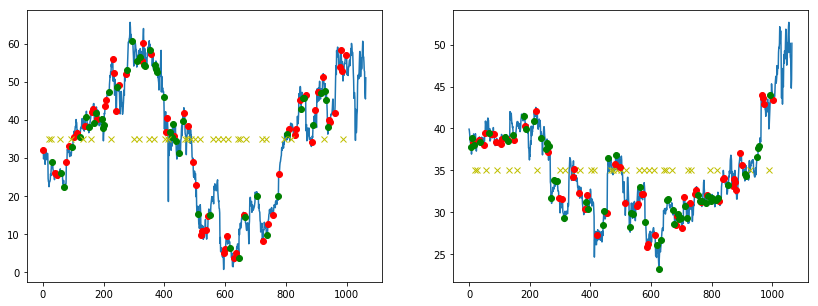

In [193]:
plt.figure(1, figsize=(14,5))
apl = plt.subplot(121)
msf = plt.subplot(122)
apl.plot(range(0, len(apl_open)), apl_open)
msf.plot(range(0, len(msf_open)), msf_open)
apl.plot(ba_action_times, bought_apl_at, "ro")
apl.plot(sa_action_times, sold_apl_at, "go")
apl.plot(n_action_times, nothing_at, "yx")
msf.plot(n_action_times, nothing_at, "yx")
msf.plot(bm_action_times, bought_msf_at, "ro")
msf.plot(sm_action_times, sold_msf_at, "go")

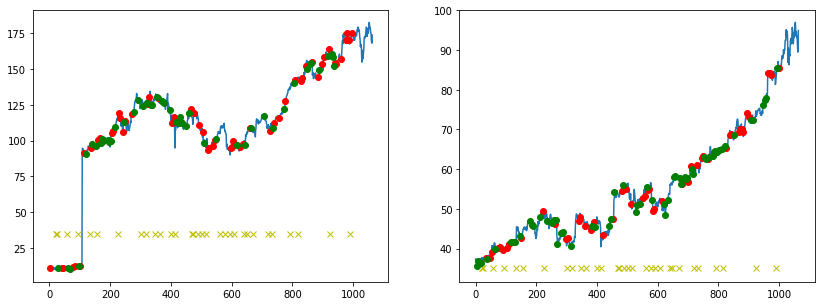

In [206]:
plt.figure(1, figsize=(14,5))
apl = plt.subplot(121)
msf = plt.subplot(122)
apl.plot(range(0, len(apl_open_orig)), apl_open_orig)
msf.plot(range(0, len(msf_open_orig)), msf_open_orig)
apl.plot(ba_action_times, bought_apl_at_orig, "ro")
apl.plot(sa_action_times, sold_apl_at_orig, "go")
apl.plot(n_action_times, nothing_at, "yx")
msf.plot(n_action_times, nothing_at, "yx")
msf.plot(bm_action_times, bought_msf_at_orig, "ro")
msf.plot(sm_action_times, sold_msf_at_orig, "go")